# Import Libraries

In [17]:
import pandas as pd 
from matplotlib import pyplot as plt 
import numpy as np 
import seaborn as sns 
import lightgbm as lgb 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
from choices import param_dict 
from utilities import deets

# Load data

In [62]:
x = pd.read_csv('compiled_data_v3/x_phot_minmax.csv' , index_col='name')
x_col = x.columns.to_list()
i = pd.read_csv('compiled_data_v3/id_frame.csv' , index_col='name')
df = pd.merge(i,x , left_index =True , right_index =True )
df = df[df['offset']<1.01]
feat_to_drop = np.unique(param_dict['hardness'] + param_dict['IRAC']+[
    '0p5_2csc' , '2-10 keV (XMM)' , '1_2_csc' , '0p5_8_csc'
]+['var_inter_hard_prob_hs', 'ks_intra_prob_b', 'var_inter_hard_sigma_hm', 'var_inter_hard_prob_ms', 'var_inter_hard_prob_hm',] )


classes = ['AGN' ,'STAR' ,'YSO' ,'HMXB' , 'LMXB' , 'ULX' ,'CV' , 'PULSAR']
df = df[df['class'].isin(classes)]
#from sklearn.preprocessing import LabelEncoder
#y_int = LabelEncoder().fit_transform(df['class'])
deets(df,1)
u = pd.read_csv('compiled_data_v3/x_phot_minmax-unid-var-src.csv' , index_col='name')
u = u.drop(columns=feat_to_drop)
u.columns = u.columns.str.replace(' ' ,'_' , regex=False)
x = df[x_col]
x = x.drop(columns=feat_to_drop)
x.columns = x.columns.str.replace(' ' ,'_' , regex=False)
y = df['class']
deets(x)
deets(u)

_____________________________________________________
------------------------------
Number of Objects : 7703
Number of Columns : 73
------------------------------


STAR      2790
AGN       2395
YSO       1149
HMXB       748
ULX        211
CV         166
LMXB       143
PULSAR     101
Name: class, dtype: int64

_____________________________________________________
_____________________________________________________
------------------------------
Number of Objects : 7703
Number of Columns : 41
_____________________________________________________
_____________________________________________________
------------------------------
Number of Objects : 39893
Number of Columns : 41
_____________________________________________________


# Classification

In [63]:
from sklearn.model_selection import train_test_split
x_train,x_test , y_train , y_test = train_test_split(x,y , test_size = 0.2 , stratify=y)

## Cross validation

In [76]:
from utilities import simple_cv
param = {
    'objective': 'binaryclass',
    'num_class':len(np.unique(y)),
    'metric': ['auc_mu' , ] , 
    'verbosity' : 2 , 
    'deterministic' : True  , 
    'early_stopping_round' : 20 , 
    'sparse' : True , 
    'is_unbalance' : True
    }
def calc_weight(gamma , y):
    l = len(y)
    cl_weight = {}
    cl_dict = y.value_counts().to_dict()
    for cl , val in zip(cl_dict.keys() , cl_dict.values()):
        w = np.exp((l / val)*gamma)
        cl_weight[cl] = w
    print(cl_weight)
    return cl_weight

### Focal Loss

In [6]:
clf = lgb.LGBMClassifier(n_estimators=100 ,class_weight = cl_weight , objective= 'multiclass', sparse=True , is_unbalance=True , metric=['auc_mu'] ,verbosity = 0 , random_state=42 , num_class=len(np.unique(y)) ,force_col_wise=True)
from OneVsRestLightGBMWithCustomizedLoss import *
from FocalLoss import FocalLoss #get the FocalLoss implementation from Halford's blog
loss = FocalLoss(alpha=0.05, gamma=0.5)
clf = OneVsRestLightGBMWithCustomizedLoss(loss=loss)
res_arr = []
from tqdm import tqdm
ret_dict= {
 'clf': True,
 'prob_table': True,
 'acc': 0,
 'pr_score': 0,
 'precision':0,
 'recall': 0 , 
 'roc_auc_score' : 0
 }
from sklearn.preprocessing import LabelEncoder 
le = LabelEncoder()
y_int = pd.Series(le.fit_transform(y) , index = y.index.to_list() , name='class')
for i in tqdm(range(1)):
    res = simple_cv(x,y ,model=clf , k=10 , normalize_prob=0 , focal_loss = True)
    #print(res['class_scores'].to_markdown())
    res_arr.append(res)

  0%|          | 0/1 [00:00<?, ?it/s]

>>> GOING for 1 / 10 Iteration FOLD
>>> GOING for 2 / 10 Iteration FOLD
>>> GOING for 3 / 10 Iteration FOLD
>>> GOING for 4 / 10 Iteration FOLD
>>> GOING for 5 / 10 Iteration FOLD
>>> GOING for 6 / 10 Iteration FOLD
>>> GOING for 7 / 10 Iteration FOLD
>>> GOING for 8 / 10 Iteration FOLD
>>> GOING for 9 / 10 Iteration FOLD
>>> GOING for 10 / 10 Iteration FOLD


100%|██████████| 1/1 [02:13<00:00, 133.35s/it]


In [36]:
res

{'classes': array(['AGN', 'CV', 'HMXB', 'LMXB', 'PULSAR', 'STAR', 'ULX', 'YSO'],
       dtype=object),
 'num_src':         pred_class
 STAR          2804
 AGN           2450
 YSO           1215
 HMXB           747
 ULX            173
 LMXB           119
 CV             117
 PULSAR          78,
 'balanced_accuracy': 0.7500473308745588,
 'accuracy': 0.9280799688433078,
 'precision': 0.9241194214043404,
 'recall': 0.9280799688433078,
 'f1': 0.9251730614617227,
 'class_scores':         recall_score  precision_score  f1_score
 class                                          
 AGN         0.980376         0.958367  0.969247
 CV          0.481928         0.683761  0.565371
 HMXB        0.893048         0.894244  0.893645
 LMXB        0.783217         0.941176  0.854962
 PULSAR      0.297030         0.384615  0.335196
 STAR        0.955914         0.951141  0.953522
 ULX         0.644550         0.786127  0.708333
 YSO         0.964317         0.911934  0.937394,
 'res_table':                  

### Train Classifier One Vs Rest

In [125]:
class make_model():
    def __init__(self , name , clf , gamma ,x ,y):
        self.name = name 
        self.clf = clf 
        self.gamma = gamma 
        self.x = x 
        self.y = y 

    def calc_weight(self):
        import numpy as np 
        l = len(self.y)
        cl_weight = {}
        cl_dict = y.value_counts().to_dict()
        for cl , val in zip(cl_dict.keys() , cl_dict.values()):
            w = np.exp((l / val)*self.gamma)
            cl_weight[cl] = w
        #print(cl_weight)
        return cl_weight
        
    def validate(self , fname= '' , k=10 , normalize_prob=0 , score_average = 'macro'):
        from utilities import simple_cv
        #self.weight = self.calc_weight(self.gamma ,self.y)
        res = simple_cv(self.x,self.y , model=self.clf , k=k , normalize_prob=normalize_prob , score_average = score_average)
        res['gamma'] = self.gamma 
        #res['class_weight'] = calc_weight(slef)
        print(res['class_scores'].to_markdown())
        self.result = res
        if(fname):
            import joblib
            joblib.dump(res , fname)
        return self
    
    def train(self):
        clf = self.clf
        clf.fit(self.x , self.y)
        return self
    def save(self , fname):
        import joblib
        joblib.dump(self , fname)

In [126]:
gamma = 0.016 
clf = lgb.LGBMClassifier(n_estimators=100 ,class_weight = calc_weight(0.016 ,y) , objective= 'multiclassova', sparse=True , is_unbalance=True , metric=['auc_mu'] ,verbosity = -1 , random_state=42 , num_class=len(np.unique(y)) ,force_col_wise=True)
model = make_model('lightGBM-ova' , clf ,gamma , x,y)

{'STAR': 1.0451651491499796, 'AGN': 1.0528076446281467, 'YSO': 1.1132297201052008, 'HMXB': 1.1791219525412917, 'ULX': 1.793400868974281, 'CV': 2.101093306352409, 'LMXB': 2.3675937070215403, 'PULSAR': 3.3881268861368703}


In [127]:
model.validate(k=10)


>>> GOING for 1 / 10 Iteration FOLD
>>> GOING for 2 / 10 Iteration FOLD
>>> GOING for 3 / 10 Iteration FOLD
>>> GOING for 4 / 10 Iteration FOLD
>>> GOING for 5 / 10 Iteration FOLD
>>> GOING for 6 / 10 Iteration FOLD
>>> GOING for 7 / 10 Iteration FOLD
>>> GOING for 8 / 10 Iteration FOLD
>>> GOING for 9 / 10 Iteration FOLD
>>> GOING for 10 / 10 Iteration FOLD
| class   |   recall_score |   precision_score |   f1_score |
|:--------|---------------:|------------------:|-----------:|
| AGN     |       0.976618 |          0.969735 |   0.973164 |
| CV      |       0.554217 |          0.589744 |   0.571429 |
| HMXB    |       0.899733 |          0.899733 |   0.899733 |
| LMXB    |       0.79021  |          0.982609 |   0.875969 |
| PULSAR  |       0.415842 |          0.5      |   0.454054 |
| STAR    |       0.955556 |          0.959338 |   0.957443 |
| ULX     |       0.7109   |          0.724638 |   0.717703 |
| YSO     |       0.960836 |          0.918469 |   0.939175 |


In [128]:
model.train()

In [129]:
model.save('models/lightGBM-ova.pkl')

In [132]:
import joblib 
model = joblib.load('models/lightGBM-ova.pkl')
model.result

{'classes': array(['AGN', 'CV', 'HMXB', 'LMXB', 'PULSAR', 'STAR', 'ULX', 'YSO'],
       dtype=object),
 'num_src':         pred_class
 STAR          2779
 AGN           2412
 YSO           1202
 HMXB           748
 ULX            207
 CV             156
 LMXB           115
 PULSAR          84,
 'balanced_accuracy': 0.7829887943571885,
 'accuracy': 0.9319745553680384,
 'precision': 0.8180330445258841,
 'recall': 0.7829887943571885,
 'f1': 0.7985836912705434,
 'class_scores':         recall_score  precision_score  f1_score
 class                                          
 AGN         0.976618         0.969735  0.973164
 CV          0.554217         0.589744  0.571429
 HMXB        0.899733         0.899733  0.899733
 LMXB        0.790210         0.982609  0.875969
 PULSAR      0.415842         0.500000  0.454054
 STAR        0.955556         0.959338  0.957443
 ULX         0.710900         0.724638  0.717703
 YSO         0.960836         0.918469  0.939175,
 'res_table':                  

#### Tune gamma

In [47]:
gamma_score = {}

In [58]:
def calc_weight(gamma):
    l = len(y_train)
    cl_weight = {}
    cl_dict = y_train.value_counts().to_dict()
    for cl , val in zip(cl_dict.keys() , cl_dict.values()):
        w = np.exp((l / val)*gamma)
        cl_weight[cl] = w
    print(cl_weight)
    return cl_weight


In [62]:
def get_res(gamma):
    clf = lgb.LGBMClassifier(n_estimators=50 ,class_weight = calc_weight(gamma) , objective= 'multiclassova', sparse=True , is_unbalance=True , metric=['auc_mu'] ,verbosity = -1 , random_state=42 , num_class=len(np.unique(y)) ,force_col_wise=True)
    from tqdm import tqdm
    res = simple_cv(x,y ,model=clf , k = 15 , normalize_prob=0)
    temp = {}
    temp['score'] = res['class_scores'] 
    temp['pred_table'] = res['res_table']
    return(temp)

In [142]:
import joblib
for gamma in tqdm([0.076 , 0.082 , 0.084 , 0.086 ]):
    gamma_score[gamma] = get_res(gamma) 
    display(gamma_score[gamma]['score'])
    joblib.dump(gamma_score, 'gamma_tune_dict')

  0%|          | 0/4 [00:00<?, ?it/s]

{'STAR': 1.233452569523494, 'AGN': 1.2768826935909376, 'YSO': 1.6646063738015768, 'HMXB': 2.1883119221194036, 'ULX': 15.975829488477357, 'CV': 33.82306131094451, 'LMXB': 60.82494594669641, 'PULSAR': 324.2872281228982}
>>> GOING for 1 / 15 Iteration FOLD
>>> GOING for 2 / 15 Iteration FOLD
>>> GOING for 3 / 15 Iteration FOLD
>>> GOING for 4 / 15 Iteration FOLD
>>> GOING for 5 / 15 Iteration FOLD
>>> GOING for 6 / 15 Iteration FOLD
>>> GOING for 7 / 15 Iteration FOLD
>>> GOING for 8 / 15 Iteration FOLD
>>> GOING for 9 / 15 Iteration FOLD
>>> GOING for 10 / 15 Iteration FOLD
>>> GOING for 11 / 15 Iteration FOLD
>>> GOING for 12 / 15 Iteration FOLD
>>> GOING for 13 / 15 Iteration FOLD
>>> GOING for 14 / 15 Iteration FOLD
>>> GOING for 15 / 15 Iteration FOLD


,recall_score,precision_score,f1_score
class,,,
AGN,0.930271,0.975482,0.952340
CV,0.608434,0.437229,0.508816
HMXB,0.846257,0.908178,0.876125
LMXB,0.825175,0.880597,0.851986
PULSAR,0.653465,0.229167,0.339332
STAR,0.928315,0.976621,0.951856
ULX,0.748815,0.542955,0.629482
YSO,0.913838,0.932504,0.923077


 25%|██▌       | 1/4 [00:48<02:25, 48.49s/it]

{'STAR': 1.2540542720614913, 'AGN': 1.3017612598977, 'YSO': 1.7329399667064187, 'HMXB': 2.32787660034384, 'ULX': 19.88262339111825, 'CV': 44.662213991169, 'LMXB': 84.12600963298574, 'PULSAR': 511.8717339749572}
>>> GOING for 1 / 15 Iteration FOLD
>>> GOING for 2 / 15 Iteration FOLD
>>> GOING for 3 / 15 Iteration FOLD
>>> GOING for 4 / 15 Iteration FOLD
>>> GOING for 5 / 15 Iteration FOLD
>>> GOING for 6 / 15 Iteration FOLD
>>> GOING for 7 / 15 Iteration FOLD
>>> GOING for 8 / 15 Iteration FOLD
>>> GOING for 9 / 15 Iteration FOLD
>>> GOING for 10 / 15 Iteration FOLD
>>> GOING for 11 / 15 Iteration FOLD
>>> GOING for 12 / 15 Iteration FOLD
>>> GOING for 13 / 15 Iteration FOLD
>>> GOING for 14 / 15 Iteration FOLD
>>> GOING for 15 / 15 Iteration FOLD


,recall_score,precision_score,f1_score
class,,,
AGN,0.924843,0.977062,0.950236
CV,0.560241,0.404348,0.469697
HMXB,0.847594,0.916185,0.880556
LMXB,0.804196,0.864662,0.833333
PULSAR,0.603960,0.187117,0.285714
STAR,0.922581,0.972422,0.946846
ULX,0.720379,0.510067,0.597250
YSO,0.899913,0.931532,0.915449


 50%|█████     | 2/4 [01:27<01:25, 42.93s/it]

{'STAR': 1.260997690888761, 'AGN': 1.3101613704188086, 'YSO': 1.7563356074868888, 'HMXB': 2.376348860165274, 'ULX': 21.38669994175984, 'CV': 48.998489626383964, 'LMXB': 93.73025718358646, 'PULSAR': 595.9890069748787}
>>> GOING for 1 / 15 Iteration FOLD
>>> GOING for 2 / 15 Iteration FOLD
>>> GOING for 3 / 15 Iteration FOLD
>>> GOING for 4 / 15 Iteration FOLD
>>> GOING for 5 / 15 Iteration FOLD
>>> GOING for 6 / 15 Iteration FOLD
>>> GOING for 7 / 15 Iteration FOLD
>>> GOING for 8 / 15 Iteration FOLD
>>> GOING for 9 / 15 Iteration FOLD
>>> GOING for 10 / 15 Iteration FOLD
>>> GOING for 11 / 15 Iteration FOLD
>>> GOING for 12 / 15 Iteration FOLD
>>> GOING for 13 / 15 Iteration FOLD
>>> GOING for 14 / 15 Iteration FOLD
>>> GOING for 15 / 15 Iteration FOLD


,recall_score,precision_score,f1_score
class,,,
AGN,0.923173,0.974868,0.948317
CV,0.548193,0.399123,0.461929
HMXB,0.844920,0.914616,0.878388
LMXB,0.811189,0.846715,0.828571
PULSAR,0.603960,0.187117,0.285714
STAR,0.922581,0.974262,0.947717
ULX,0.744076,0.528620,0.618110
YSO,0.905135,0.933573,0.919134


 75%|███████▌  | 3/4 [02:02<00:39, 39.20s/it]

{'STAR': 1.2679795538775671, 'AGN': 1.3186156858536298, 'YSO': 1.780047102260021, 'HMXB': 2.4258304346436144, 'ULX': 23.00455656184641, 'CV': 53.75577632899193, 'LMXB': 104.4309738454125, 'PULSAR': 693.929500026426}
>>> GOING for 1 / 15 Iteration FOLD
>>> GOING for 2 / 15 Iteration FOLD
>>> GOING for 3 / 15 Iteration FOLD
>>> GOING for 4 / 15 Iteration FOLD
>>> GOING for 5 / 15 Iteration FOLD
>>> GOING for 6 / 15 Iteration FOLD
>>> GOING for 7 / 15 Iteration FOLD
>>> GOING for 8 / 15 Iteration FOLD
>>> GOING for 9 / 15 Iteration FOLD
>>> GOING for 10 / 15 Iteration FOLD
>>> GOING for 11 / 15 Iteration FOLD
>>> GOING for 12 / 15 Iteration FOLD
>>> GOING for 13 / 15 Iteration FOLD
>>> GOING for 14 / 15 Iteration FOLD
>>> GOING for 15 / 15 Iteration FOLD


,recall_score,precision_score,f1_score
class,,,
AGN,0.926931,0.975824,0.950749
CV,0.590361,0.403292,0.479218
HMXB,0.823529,0.916667,0.867606
LMXB,0.811189,0.872180,0.840580
PULSAR,0.673267,0.193732,0.300885
STAR,0.917204,0.974115,0.944803
ULX,0.739336,0.528814,0.616601
YSO,0.902524,0.936766,0.919326


100%|██████████| 4/4 [02:35<00:00, 38.91s/it]


In [20]:
import joblib
gamma_score = joblib.load('gamma_tune_dict')
gamma_score.keys()

dict_keys([0.1, 0.005, 0.0, 0.2, 0.05, 0.15, 0.02, 0.04, 0.08, 0.09, 0.012, 0.014, 0.016, 0.018, 0.076, 0.082, 0.084, 0.086])

In [21]:
gdf = []
for g , v in zip(gamma_score.keys() , gamma_score.values()):
    df_temp = pd.DataFrame({
        'gamma' : g , 
        'class' : v['score'].index.to_list() , 
        'precision' : v['score']['precision_score'].to_list() , 
        'recall' : v['score']['recall_score'].to_list() , 
        'f1' : v['score']['f1_score'].to_list() , 
    })
    gdf.append(df_temp)
gdf = pd.concat(gdf).reset_index(drop=True)
gdf

,gamma,class,precision,recall,f1
0,0.100,AGN,0.973909,0.903967,0.937635
1,0.100,CV,0.367257,0.500000,0.423469
2,0.100,HMXB,0.860563,0.816845,0.838134
3,0.100,LMXB,0.874074,0.825175,0.848921
4,0.100,PULSAR,0.171355,0.663366,0.272358
...,...,...,...,...,...
139,0.086,LMXB,0.872180,0.811189,0.840580
140,0.086,PULSAR,0.193732,0.673267,0.300885
141,0.086,STAR,0.974115,0.917204,0.944803
142,0.086,ULX,0.528814,0.739336,0.616601


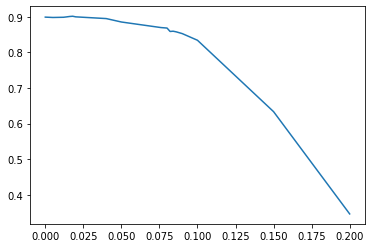

In [33]:
# MCC coefficient
gamma_score[0.1]['pred_table']
mcc = []
from sklearn.metrics import matthews_corrcoef
for g in gamma_score.keys():
    pred_table = gamma_score[g]['pred_table']
    mcc.append(matthews_corrcoef(pred_table['true_class'] , pred_table['pred_class']))
mcc_df = pd.DataFrame({
    'gamma' : gamma_score.keys() , 
    'mcc' : mcc
}).sort_values(by = 'gamma').reset_index(drop=True)
plt.plot(mcc_df['gamma'] , mcc_df['mcc'])
plt.show()

In [34]:
mcc_df

,gamma,mcc
0,0.000,0.898815
1,0.005,0.897854
2,0.012,0.898436
3,0.014,0.899490
4,0.016,0.900639
5,0.018,0.901305
6,0.020,0.899591
7,0.040,0.894772
8,0.050,0.885134
9,0.076,0.869498


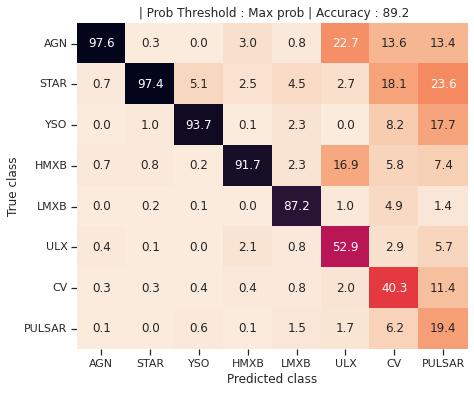

In [43]:
g = 0.086
from utilities import plot_cf 
plot_cf([gamma_score[g]['pred_table']] , normalize='pred')

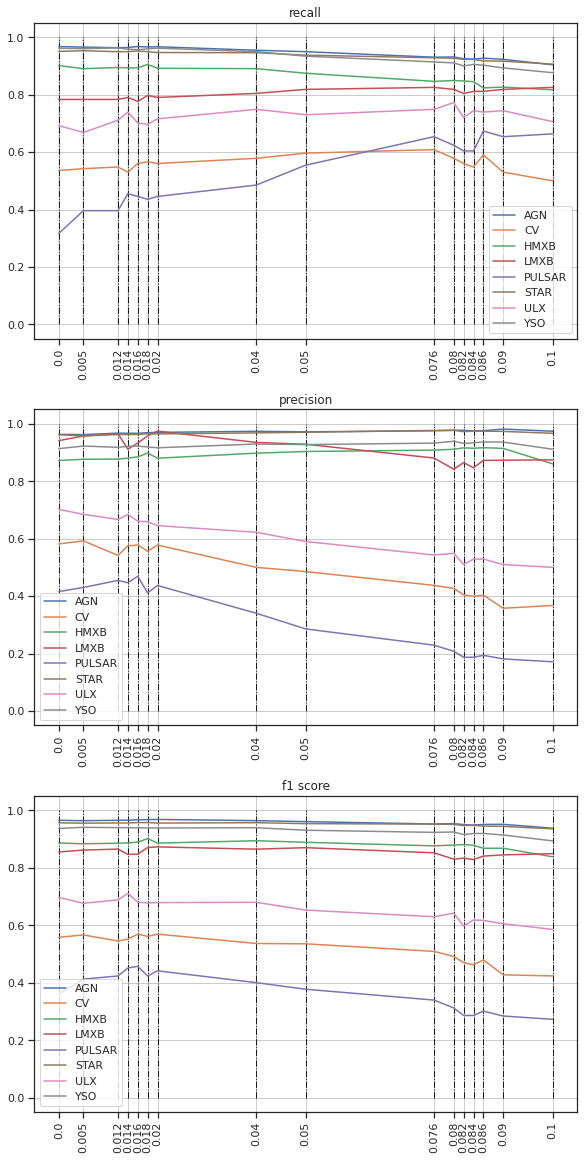

In [44]:
fig , ax = plt.subplots(nrows=3 , ncols=1 ,  figsize=(8,16) ,  constrained_layout=True)
for cl in np.unique(gdf['class']):
    temp = gdf[gdf['class']==cl].sort_values(by='gamma')
    temp = temp[temp['gamma']<0.15]
    ax[0].plot(temp['gamma'] , temp['recall'] , label=cl)
    ax[0].vlines(temp['gamma'] , ymin = 0 , ymax=1 , linewidth=0.1 , color='k' , alpha=0.2 , linestyle='-.')
    ax[0].set_title('recall')
    ax[1].plot(temp['gamma'] , temp['precision'] , label=cl)
    ax[1].set_title('precision')
    ax[2].plot(temp['gamma'] , temp['f1'] , label=cl)
    ax[2].set_title('f1 score')
    plt.legend()
    #plt.xlim(0 , 0.15)
for a in ax:
    #a.grid()
    a.set_xticks(temp['gamma'] , )
    a.set_xticklabels(temp['gamma'], rotation=90)
    a.vlines(temp['gamma'] , ymin = 0 , ymax=1 , linewidth=1 , color='k' , alpha=1, linestyle='-.')
    a.legend()
plt.show()

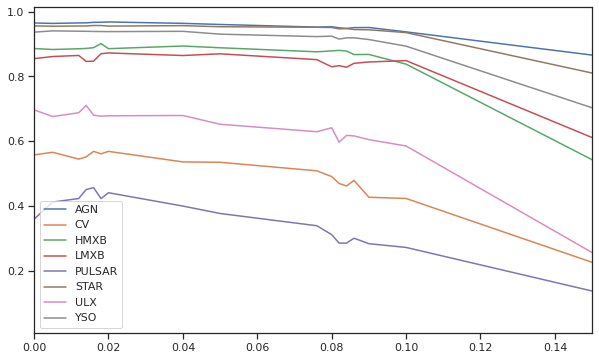

In [45]:
plt.figure(figsize=(10,6))
for cl in np.unique(gdf['class']):
    temp = gdf[gdf['class']==cl].sort_values(by='gamma')
    plt.plot(temp['gamma'] , temp['f1'] , label=cl)
    plt.xlim(0 , 0.15)
plt.legend()
ax = plt.gca()
plt.grid()
plt.show()

#### Score analysis

In [72]:
score_df_ova2 = pd.concat([el['class_scores'] for el in res_arr_ova]).reset_index().sort_values(by='recall_score')
score_df_ova2.to_csv('temp_res_comp/scores/LightGBM-ovaclass-w-0.09-without-gal-coord.csv')

In [18]:
score_df_ova = pd.concat([el['class_scores'] for el in res_arr_ova]).reset_index().sort_values(by='recall_score')
score_df_ova.to_csv('temp_res_comp/scores/LightGBM_ovaclass_w-0.05.csv')

In [ ]:
#score_df = pd.concat([el['class_scores'] for el in res_arr]).reset_index().sort_values(by='recall_score')
#score_df.to_csv('temp_res_comp/scores/LightGBM_allclass.csv')
score_df= pd.read_csv('temp_res_comp/scores/LightGBM-allclass.csv')
score_df

,Unnamed: 0,class,recall_score,precision_score,f1_score
0,12,PULSAR,0.45,0.38,0.41
1,52,PULSAR,0.45,0.37,0.40
2,20,PULSAR,0.46,0.37,0.41
3,28,PULSAR,0.47,0.39,0.43
4,60,PULSAR,0.48,0.38,0.42
...,...,...,...,...,...
75,56,AGN,0.97,0.97,0.97
76,0,AGN,0.97,0.97,0.97
77,64,AGN,0.97,0.97,0.97
78,40,AGN,0.97,0.97,0.97


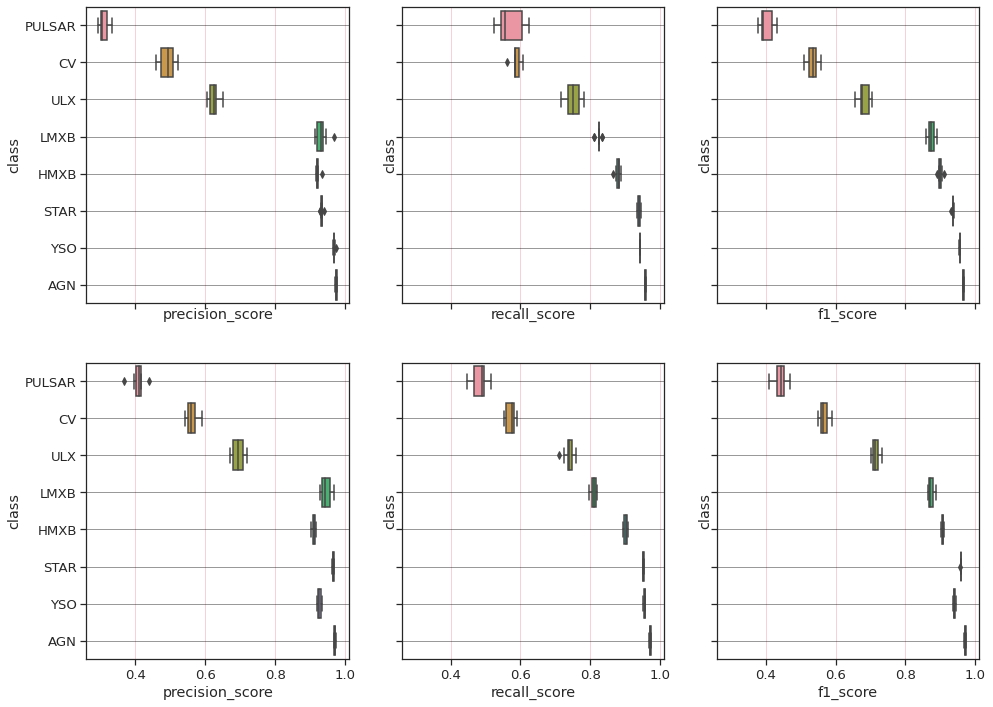

In [ ]:
fig , ax = plt.subplots(nrows=2 , ncols=3 , sharey=True ,sharex=True ,  figsize= (16,12))
sns.set_palette('vlag')
sns.boxplot(data = score_df_ova2 ,  y = 'class' , x = 'precision_score' , ax=ax[0][0])
sns.boxplot(data = score_df_ova2 ,  y = 'class' , x = 'recall_score' , ax=ax[0][1])
sns.boxplot(data = score_df_ova2 ,  y = 'class' , x = 'f1_score' , ax=ax[0][2])

sns.boxplot(data = score_df_ova ,  y = 'class' , x = 'precision_score' , ax=ax[1][0])
sns.boxplot(data = score_df_ova ,  y = 'class' , x = 'recall_score' , ax=ax[1][1])
sns.boxplot(data = score_df_ova ,  y = 'class' , x = 'f1_score' , ax=ax[1][2])
for ai in ax:
    for a in ai:
        a.yaxis.grid(True, color ="black" , alpha=0.4)
        a.xaxis.grid(True , color='crimson' , alpha=0.2)
#plt.savefig()
plt.show()

In [19]:
res['res_table']

,true_class,pred_class,pred_prob,prob_AGN,prob_CV,prob_HMXB,prob_LMXB,prob_PULSAR,prob_STAR,prob_ULX,prob_YSO
name,,,,,,,,,,,
2CXO J183122.4-621642,STAR,STAR,0.999893,0.000011,3.115960e-06,0.000802,0.000013,0.000009,0.999893,0.000002,0.000002
2CXO J091432.7+561238,STAR,STAR,0.999436,0.001137,5.217488e-07,0.000114,0.000004,0.000004,0.999436,0.000002,0.000002
2CXO J213701.3+572446,STAR,STAR,0.996884,0.000021,3.568341e-04,0.000049,0.000004,0.000227,0.996884,0.000125,0.000003
2CXO J180935.6-255553,STAR,STAR,0.999765,0.000003,1.891440e-05,0.000006,0.000025,0.000008,0.999765,0.000002,0.000005
2CXO J100038.3+013708,AGN,AGN,0.583731,0.583731,9.758183e-05,0.000011,0.000228,0.000112,0.000081,0.001313,0.000003
...,...,...,...,...,...,...,...,...,...,...,...
2CXO J133952.0-313859,HMXB,HMXB,0.999359,0.000735,7.761753e-03,0.999359,0.000009,0.028662,0.000427,0.000030,0.000002
2CXO J180223.5-230023,YSO,YSO,0.999825,0.000030,1.412598e-04,0.000011,0.000075,0.000257,0.002982,0.000016,0.999825
2CXO J022233.4+422026,ULX,CV,0.540499,0.000121,5.404986e-01,0.039702,0.009500,0.000002,0.001100,0.004956,0.000003


In [21]:
clf = res['clf']

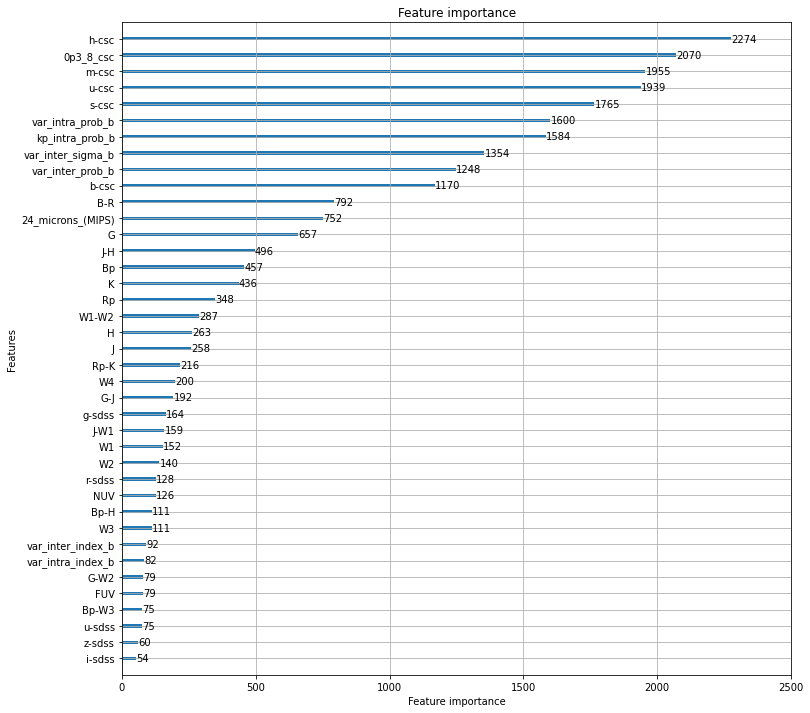

In [73]:
fig , ax = plt.subplots(nrows=1 , ncols=1 , figsize=(12,12))
lgb.plot_importance(clf , ax=ax)
plt.show()

In [74]:
import joblib

# save model
joblib.dump(clf, 'models/lgb-ova-no-gal.pkl')


['models/lgb-ova-no-gal.pkl']

In [75]:
pd.options.display.float_format = '{:,.2f}'.format
class_scores = res['class_scores']
print(class_scores.to_markdown())

| class   |   recall_score |   precision_score |   f1_score |
|:--------|---------------:|------------------:|-----------:|
| AGN     |       0.901879 |          0.957447 |   0.928833 |
| CV      |       0.415663 |          0.285124 |   0.338235 |
| HMXB    |       0.574866 |          0.659509 |   0.614286 |
| LMXB    |       0.58042  |          0.419192 |   0.486804 |
| PULSAR  |       0.425743 |          0.177686 |   0.250729 |
| STAR    |       0.88853  |          0.935825 |   0.911565 |
| ULX     |       0.578199 |          0.398693 |   0.471954 |
| YSO     |       0.830287 |          0.823834 |   0.827048 |


Text(0.5, 1.0, 'CF for LighgGBM,')

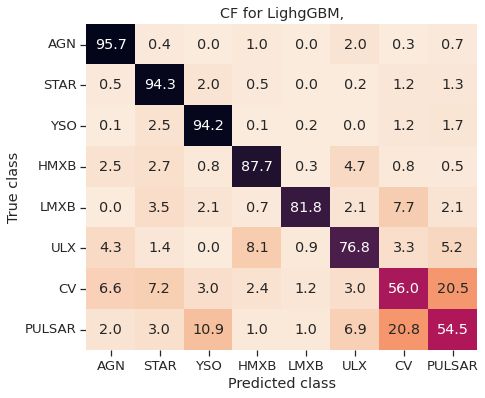

In [46]:
from utilities import plot_cf
plot_dict_def = {
    'title' : False , 
    'font_scale' : 1.2 ,
    'cbar' : False ,
    'plot_num' : 0,
}
fig , ax = plt.subplots(nrows=1 , ncols=1 , figsize=(7,6))
plot_cf([res['res_table']] , plot_dict=plot_dict_def , confidance=0. , ax=ax)
plt.title('CF for LighgGBM,')
#plt.savefig('temp_res_comp/cf/lightGBM_rf.png')

In [54]:
res['res_table'].to_csv('temp_res_comp/train_prob/lightGBM_none.csv')

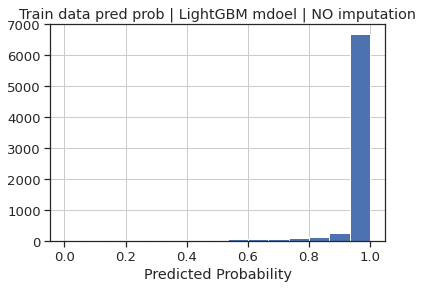

In [48]:
plt.hist(res['res_table']['pred_prob'] , bins=15)
plt.title('Train data pred prob | LightGBM mdoel | NO imputation')
plt.xlabel('Predicted Probability')
plt.savefig('temp_res_comp/train_prob_dist/LightGBM_prob.jpg')
plt.show()

## Prediction on New sources

In [48]:
# load model
import joblib
clf = joblib.load('models/lgb-ova.pkl')
clf 

LGBMClassifier(class_weight={'AGN': 1.3356883328329183, 'CV': 64.70085628321034,
                             'HMXB': 2.527906031090322,
                             'LMXB': 129.63681917019255,
                             'PULSAR': 940.7398749439147,
                             'STAR': 1.2820594649453247,
                             'ULX': 26.616689970780907,
                             'YSO': 1.8284347681624522},
               force_col_wise=True, is_unbalance=True, metric=['auc_mu'],
               num_class=8, objective='multiclassova', random_state=42,
               sparse=True, verbosity=0)

In [49]:
u = []
ui = []
for i in range(8):
    u.append(pd.read_csv(f'compiled_data_v3/unid-non-var-chunks/x-chunk-{i}.csv' , index_col='name'))
    ui.append(pd.read_csv(f'compiled_data_v3/unid-non-var-chunks/id-chunk-{i}.csv' , index_col='name'))
u = pd.concat(u)
ui = pd.concat(ui)
u = u.drop(columns=feat_to_drop)
u.columns = u.columns.str.replace(' ' ,'_' , regex=False)
u

,gal_b2,gal_l2,var_inter_prob_b,var_inter_sigma_b,var_intra_prob_b,var_inter_index_b,kp_intra_prob_b,var_intra_index_b,h-csc,b-csc,...,Rp,B-R,G-J,G-W2,Bp-H,Bp-W3,Rp-K,J-H,J-W1,W1-W2
name,,,,,,,,,,,,,,,,,,,,,
2CXO J003935.9-732725,2.561951,8.447115,NaN,NaN,2.809762,NaN,8.723285,0.0,4.972998e-06,0.003956,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2CXO J003936.7-731249,2.548397,8.447672,NaN,NaN,5.267622,NaN,3.246585,0.0,NaN,0.016586,...,8.751645,2.628340,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2CXO J004028.7-731106,2.546591,8.445331,NaN,NaN,2.001693,NaN,2.474462,0.0,NaN,0.124419,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2CXO J004506.3-730056,2.536271,8.432664,NaN,NaN,1.712439,NaN,8.102221,0.0,1.135905e-08,0.027585,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2CXO J004659.0-731918,2.553126,8.427077,NaN,NaN,2.771679,NaN,3.443930,0.0,7.595018e-09,0.004986,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2CXO J220556.3-500415,2.145628,9.595540,NaN,NaN,4.616799,NaN,0.528451,0.0,NaN,0.007289,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2CXO J220557.3-500827,2.146864,9.592593,NaN,NaN,7.608600,NaN,7.668830,10.0,2.474932e-10,0.004474,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2CXO J220600.9-501131,2.147357,9.590334,6.145112,0.001324,4.804390,5.00,8.861115,0.0,2.396984e-10,0.079301,...,8.616583,3.240831,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
from utilities import softmax , norm_prob
pred_prob = (clf.predict_proba(u))
pred_prob_df = pd.DataFrame(pred_prob , columns=[f'prob_{el}' for el in clf.classes_] , index = u.index.to_list())
pred_prob_df

,prob_AGN,prob_CV,prob_HMXB,prob_LMXB,prob_PULSAR,prob_STAR,prob_ULX,prob_YSO
2CXO J003935.9-732725,0.001508,0.959293,0.258024,0.000017,0.822071,0.035764,0.000628,0.000009
2CXO J003936.7-731249,0.008970,0.185355,0.652311,0.000007,0.802173,0.001159,0.000392,0.000003
2CXO J004028.7-731106,0.025097,0.002926,0.793752,0.000018,0.005936,0.000363,0.120180,0.000006
2CXO J004506.3-730056,0.001180,0.450570,0.012404,0.000005,0.889123,0.005013,0.304444,0.000002
2CXO J004659.0-731918,0.000578,0.078247,0.902248,0.000127,0.972335,0.121442,0.058332,0.000003
...,...,...,...,...,...,...,...,...
2CXO J220556.3-500415,0.029492,0.012188,0.518009,0.000044,0.817985,0.011788,0.001315,0.000002
2CXO J220557.3-500827,0.000318,0.008637,0.906103,0.000061,0.926332,0.000082,0.000385,0.000002
2CXO J220600.9-501131,0.006616,0.056521,0.016156,0.000023,0.937981,0.000261,0.004915,0.000002
2CXO J220601.0-501116,0.000524,0.006070,0.970174,0.000010,0.015706,0.000049,0.003017,0.000002


In [51]:
u_df = pd.DataFrame({
    'name' : u.index.to_list() , 
    'class' : clf.predict(u) , 
    'prob' : [np.amax(el) for el in pred_prob] ,
    'prob_margin' : [el[-1]-el[-2] for el in np.sort(pred_prob , axis=1 ,)]
}).set_index('name')
u_df = pd.merge(u_df , pred_prob_df , left_index=True , right_index=True)
u_df.index.name = 'name'
u_df 

,class,prob,prob_margin,prob_AGN,prob_CV,prob_HMXB,prob_LMXB,prob_PULSAR,prob_STAR,prob_ULX,prob_YSO
name,,,,,,,,,,,
2CXO J003935.9-732725,CV,0.959293,0.137223,0.001508,0.959293,0.258024,0.000017,0.822071,0.035764,0.000628,0.000009
2CXO J003936.7-731249,PULSAR,0.802173,0.149862,0.008970,0.185355,0.652311,0.000007,0.802173,0.001159,0.000392,0.000003
2CXO J004028.7-731106,HMXB,0.793752,0.673571,0.025097,0.002926,0.793752,0.000018,0.005936,0.000363,0.120180,0.000006
2CXO J004506.3-730056,PULSAR,0.889123,0.438553,0.001180,0.450570,0.012404,0.000005,0.889123,0.005013,0.304444,0.000002
2CXO J004659.0-731918,PULSAR,0.972335,0.070087,0.000578,0.078247,0.902248,0.000127,0.972335,0.121442,0.058332,0.000003
...,...,...,...,...,...,...,...,...,...,...,...
2CXO J220556.3-500415,PULSAR,0.817985,0.299976,0.029492,0.012188,0.518009,0.000044,0.817985,0.011788,0.001315,0.000002
2CXO J220557.3-500827,PULSAR,0.926332,0.020229,0.000318,0.008637,0.906103,0.000061,0.926332,0.000082,0.000385,0.000002
2CXO J220600.9-501131,PULSAR,0.937981,0.881460,0.006616,0.056521,0.016156,0.000023,0.937981,0.000261,0.004915,0.000002


In [52]:
u_df.to_csv('temp_res_comp/unid-non-var-prob/lightGBM_none.csv')

In [53]:
u_df = pd.read_csv('temp_res_comp/unid-non-var-prob/lightGBM_none.csv' , index_col='name')
u_df

,class,prob,prob_margin,prob_AGN,prob_CV,prob_HMXB,prob_LMXB,prob_PULSAR,prob_STAR,prob_ULX,prob_YSO
name,,,,,,,,,,,
2CXO J003935.9-732725,CV,0.959293,0.137223,0.001508,0.959293,0.258024,0.000017,0.822071,0.035764,0.000628,0.000009
2CXO J003936.7-731249,PULSAR,0.802173,0.149862,0.008970,0.185355,0.652311,0.000007,0.802173,0.001159,0.000392,0.000003
2CXO J004028.7-731106,HMXB,0.793752,0.673571,0.025097,0.002926,0.793752,0.000018,0.005936,0.000363,0.120180,0.000006
2CXO J004506.3-730056,PULSAR,0.889123,0.438553,0.001180,0.450570,0.012404,0.000005,0.889123,0.005013,0.304444,0.000002
2CXO J004659.0-731918,PULSAR,0.972335,0.070087,0.000578,0.078247,0.902248,0.000127,0.972335,0.121442,0.058332,0.000003
...,...,...,...,...,...,...,...,...,...,...,...
2CXO J220556.3-500415,PULSAR,0.817985,0.299976,0.029492,0.012188,0.518009,0.000044,0.817985,0.011788,0.001315,0.000002
2CXO J220557.3-500827,PULSAR,0.926332,0.020229,0.000318,0.008637,0.906103,0.000061,0.926332,0.000082,0.000385,0.000002
2CXO J220600.9-501131,PULSAR,0.937981,0.881460,0.006616,0.056521,0.016156,0.000023,0.937981,0.000261,0.004915,0.000002


In [54]:
u_pos = pd.merge(u_df[['class','prob']] , ui[['ra','dec']] ,left_index=True,right_index=True)
u_pos

,class,prob,ra,dec
name,,,,
2CXO J003935.9-732725,CV,0.959293,9.899767,-73.457136
2CXO J003936.7-731249,PULSAR,0.802173,9.903193,-73.213742
2CXO J004028.7-731106,HMXB,0.793752,10.119748,-73.185171
2CXO J004506.3-730056,PULSAR,0.889123,11.276413,-73.015666
2CXO J004659.0-731918,PULSAR,0.972335,11.745895,-73.321890
...,...,...,...,...
2CXO J220556.3-500415,PULSAR,0.817985,331.484996,-50.070913
2CXO J220557.3-500827,PULSAR,0.926332,331.489033,-50.141066
2CXO J220600.9-501131,PULSAR,0.937981,331.504140,-50.192019


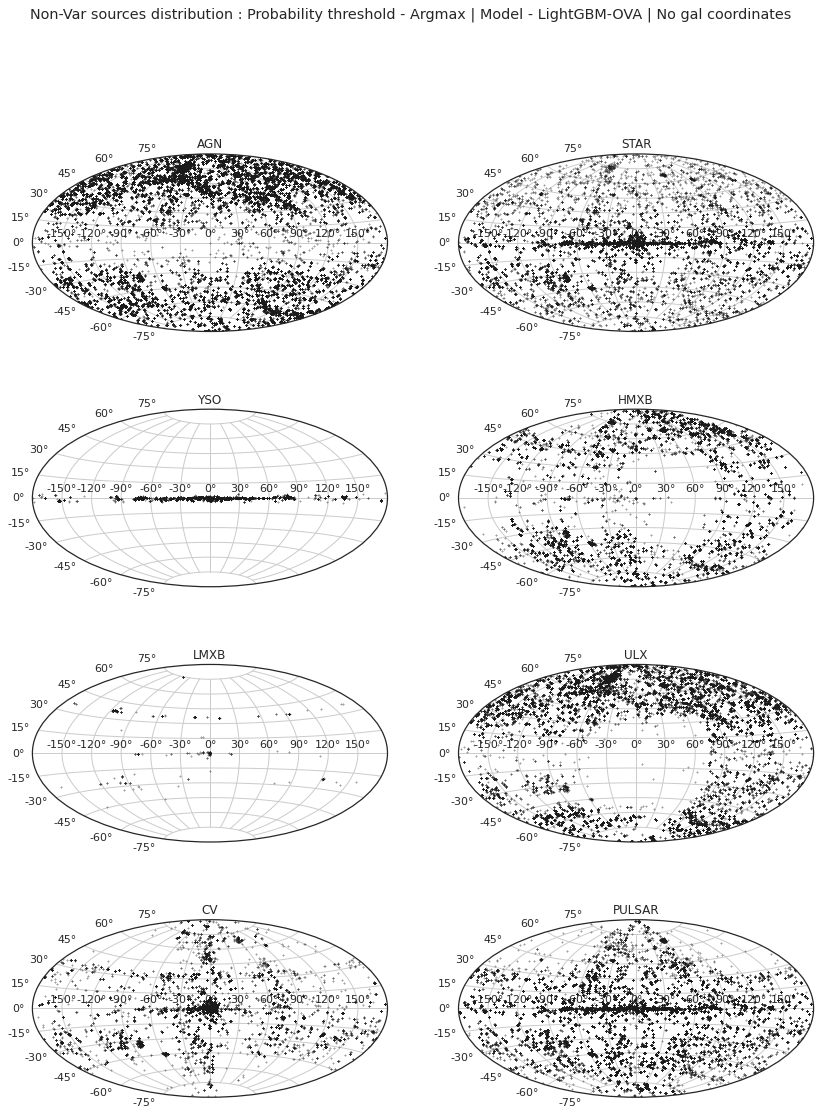

In [55]:
from astropy.coordinates import SkyCoord
from astropy import units as unit 
# plt.figure(figsize=(12,10))
# plt.subplot(111, projection='aitoff' ,)
# plt.grid(True)
colors =['black','lightcoral','lime','fuchsia', 'teal' , 'gold' , 'crimson' , 'indigo']
#fig , ax = plt.subplots(nrows=2, ncols=4 , figsize=(16,10) , projection='aitoff' ,)
k = 0
#cl = np.reshape(classes , ax.shape)
fig = plt.figure(figsize=(14, 18))
for i in range(1,9):
    #cl = classes[k]
    df_plot = u_pos[u_pos['class']==classes[i-1]]
    prob_th = 0.
    df_plot = df_plot[df_plot['prob']>prob_th]
    eq = SkyCoord(df_plot['ra'] , df_plot['dec'] , unit = unit.deg)
    gal = eq.galactic
    ax = fig.add_subplot(int(f'42{i}') , projection='aitoff')
    ax.scatter(gal.l.wrap_at('180d').radian, gal.b.radian , s=1 , marker='x',alpha=0.4 , label=classes[i-1] , color='k')
    ax.set_title(classes[i-1])
    #plt.legend()
fig.suptitle('Non-Var sources distribution : Probability threshold - Argmax | Model - LightGBM-OVA | No gal coordinates')
plt.savefig('plots/all_src_pred/lightgbm_non-var-no-gal.jpg')
plt.show()

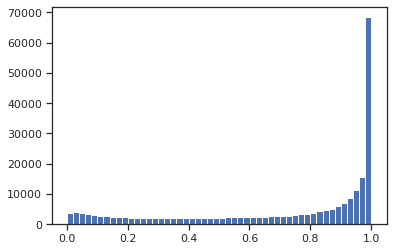

0.9800093850712066

In [56]:
x ,y ,z = plt.hist(u_df['prob'] ,bins=50)
plt.grid()
plt.show()
mode = y[np.argmax(x)]
mode

In [57]:
u_df_num = u_df['class'].value_counts().to_frame()
u_df_num = pd.concat([
                u_df['class'].value_counts() ,
                u_df[u_df['prob']>mode]['class'].value_counts(),
                u_df[u_df['prob']>0.5]['class'].value_counts(),
                u_df[u_df['prob']>0.6]['class'].value_counts(),
                u_df[u_df['prob']>0.7]['class'].value_counts(),
                u_df[u_df['prob']>0.8]['class'].value_counts(),
                u_df[u_df['prob']>0.9]['class'].value_counts(),
                u_df[u_df['prob']>0.98]['class'].value_counts(),
                 ] , axis=1)
u_df_num.columns = ['Argmax' , f"Most probable > {mode :.2f}" ,'0.5' ,'0.6' ,'0.7' ,'0.8' ,'0.9' ,'0.98']
u_df_num.index.name = 'class'
#u_df_num.to_csv(f'temp_res_comp/unid_num/{d_name}_{m_name}.csv')
u_df_num.append(u_df_num.sum() , ignore_index=True)
print(u_df_num.to_markdown())

| class   |   Argmax |   Most probable > 0.98 |   0.5 |   0.6 |   0.7 |   0.8 |   0.9 |   0.98 |
|:--------|---------:|-----------------------:|------:|------:|------:|------:|------:|-------:|
| AGN     |    66390 |                  25279 | 54354 | 51796 | 48725 | 44733 | 37909 |  25282 |
| PULSAR  |    39429 |                  11727 | 29821 | 27951 | 25780 | 23150 | 19247 |  11732 |
| STAR    |    34400 |                  13332 | 26788 | 25369 | 23942 | 22220 | 19500 |  13334 |
| ULX     |    33199 |                   4428 | 22497 | 20412 | 18024 | 15101 | 10975 |   4430 |
| HMXB    |    27362 |                   7095 | 19093 | 17766 | 16343 | 14557 | 11858 |   7096 |
| CV      |    17929 |                   1283 |  8162 |  7062 |  5758 |  4588 |  3099 |   1283 |
| YSO     |    17889 |                   5111 | 14208 | 13197 | 12006 | 10597 |  8421 |   5111 |
| LMXB    |      578 |                    151 |   345 |   332 |   313 |   186 |   169 |    151 |


In [58]:
from numpy.random import normal
from ridgeplot import ridgeplot
cl = classes[::-1]
sample = [u_df[u_df['class']==c]['prob'] for c in cl]
fig = ridgeplot(
    samples=sample,
    kde_points=np.linspace(0, 1, 500),
    colorscale="inferno",
    colormode="index",
    coloralpha=0.6,
    labels=cl,
    spacing = 3 / 8,
    xpad=0
)
fig.update_layout(
    title="Unidentified sources | No Imputation | LightGBM classifier",
    height=550,
    width=600,
    plot_bgcolor="rgba(255, 255, 255, 0.0)",
    xaxis_gridcolor="rgba(0, 0, 0, 0.1)",
    yaxis_gridcolor="rgba(0, 0, 0, 0.1)",
    xaxis_title="Predicted Probability",
    yaxis_title="Predicted Probability Density",
)

#fig.save('temp.png')
#fig.write_image('temp_res_comp/unid_prob_dist/lightGBM_none.jpg')
fig.show()

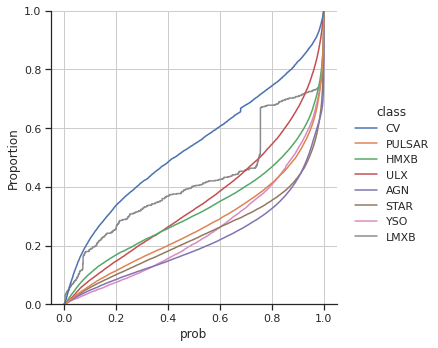

In [59]:
sns.displot(
    data = u_df ,
    kind='ecdf' ,
    x = 'prob' ,
    hue = 'class'
)
#plt.savefig('plots/higher_models/lbg_unid_prob.jpg')
plt.show()